In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

## Data preprocessing

In [16]:
data = pd.read_csv('credit_score.csv')
data = data.drop(columns=['Unnamed: 0'])
data['Salary'] = data['Salary'] / 2
data.head(5)

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose   Salary  
0         6             radio/TV   8858.0  
1        48             radio/TV  11068.0  
2        12            education   8481.5  
3        42  furniture/equipment   7886.5  
4        24                  car   9756.5

In [17]:
data.shape

(1000, 10)

In [18]:
data.describe().T

count       mean          std     min     25%       50%  \
Age            1000.0     35.546    11.375469    19.0    27.0     33.00   
Job            1000.0      1.904     0.653614     0.0     2.0      2.00   
Credit amount  1000.0   3271.258  2822.736876   250.0  1365.5   2319.50   
Duration       1000.0     20.903    12.058814     4.0    12.0     18.00   
Salary         1000.0  11077.263  2909.938490  7507.0  8782.0  10337.75   

                     75%      max  
Age               42.000     75.0  
Job                2.000      3.0  
Credit amount   3972.250  18424.0  
Duration          24.000     72.0  
Salary         12599.375  18733.5

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   object 
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   object 
 4   Saving accounts   817 non-null    object 
 5   Checking account  606 non-null    object 
 6   Credit amount     1000 non-null   int64  
 7   Duration          1000 non-null   int64  
 8   Purpose           1000 non-null   object 
 9   Salary            1000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 78.3+ KB


In [20]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Salary              968
dtype: int64

#### Check for missed data and fill it

In [21]:
data['Saving accounts'] = data['Saving accounts'].fillna('unk')
data['Checking account'] = data['Checking account'].fillna('unk')
data.head(3)

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             unk           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              unk           2096   

   Duration    Purpose   Salary  
0         6   radio/TV   8858.0  
1        48   radio/TV  11068.0  
2        12  education   8481.5

#### Make categorial features

In [22]:
categorial_features = ['Sex', 'Housing', 'Checking account', 'Purpose']
order = [['unk', 'little', 'moderate', 'quite rich', 'rich']]

#### Code categorial data to numeric vectors for model implementation

In [23]:
oe = OrdinalEncoder(categories=order)
data['Saving accounts'] = oe.fit_transform(data[['Saving accounts']])

In [24]:
ohe = OneHotEncoder(handle_unknown='ignore')
encoded = ohe.fit_transform(data[categorial_features]).toarray()

In [25]:
encoded_data = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorial_features))
data = pd.concat([data, encoded_data], axis=1).drop(categorial_features, axis=1)
data.head(7)

Age  Job  Saving accounts  Credit amount  Duration   Salary  Sex_female  \
0   67    2              0.0           1169         6   8858.0         0.0   
1   22    2              1.0           5951        48  11068.0         1.0   
2   49    1              1.0           2096        12   8481.5         0.0   
3   45    2              1.0           7882        42   7886.5         0.0   
4   53    2              1.0           4870        24   9756.5         0.0   
5   35    1              0.0           9055        36  15326.5         0.0   
6   53    2              3.0           2835        24  14698.0         0.0   

   Sex_male  Housing_free  Housing_own  ...  Checking account_rich  \
0       1.0           0.0          1.0  ...                    0.0   
1       0.0           0.0          1.0  ...                    0.0   
2       1.0           0.0          1.0  ...                    0.0   
3       1.0           1.0          0.0  ...                    0.0   
4       1.0           1.0          0.0  ...                    0.0   
5       1.0           1.0          0.0  ...                    0.0   
6       1.0           0.0          1.0  ...                    0.0   

   Checking account_unk  Purpose_business  Purpose_car  \
0                   0.0               0.0          0.0   
1                   0.0               0.0          0.0   
2                   1.0               0.0          0.0   
3                   0.0               0.0          0.0   
4                   0.0               0.0          1.0   
5                   1.0               0.0          0.0   
6                   1.0               0.0          0.0   

   Purpose_domestic appliances  Purpose_education  \
0                          0.0                0.0   
1                          0.0                0.0   
2                          0.0                1.0   
3                          0.0                0.0   
4                          0.0                0.0   
5                          0.0                1.0   
6                          0.0                0.0   

   Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  \
0                          0.0               1.0              0.0   
1                          0.0               1.0              0.0   
2                          0.0               0.0              0.0   
3                          1.0               0.0              0.0   
4                          0.0               0.0              0.0   
5                          0.0               0.0              0.0   
6                          1.0               0.0              0.0   

   Purpose_vacation/others  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  

[7 rows x 23 columns]

## Let's look at age, credit amount, credit duration distributions and features correlation

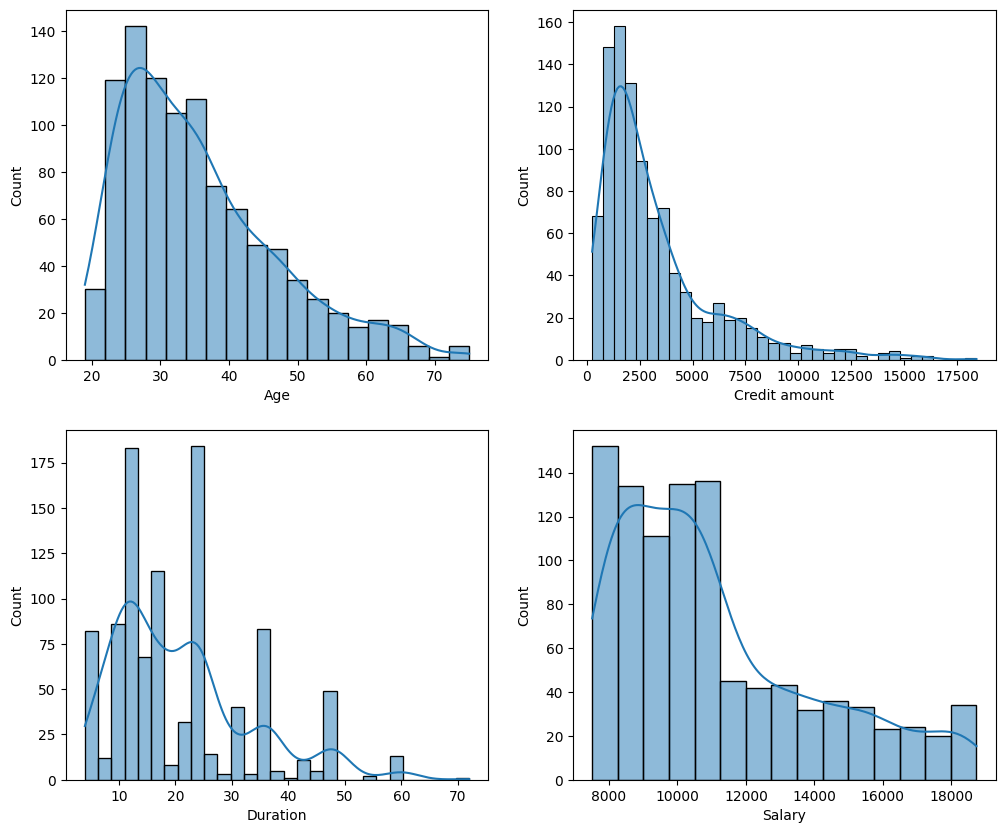

In [26]:
subplot_name = ['Age', 'Credit amount', 'Duration', 'Salary']

n = 1
indx = 0

plt.figure(figsize=(12, 10))

for i in range(4):
    plt.subplot(2, 2, n)
    sns.histplot(x=data[subplot_name[indx]], kde=True)

    n += 1
    indx += 1

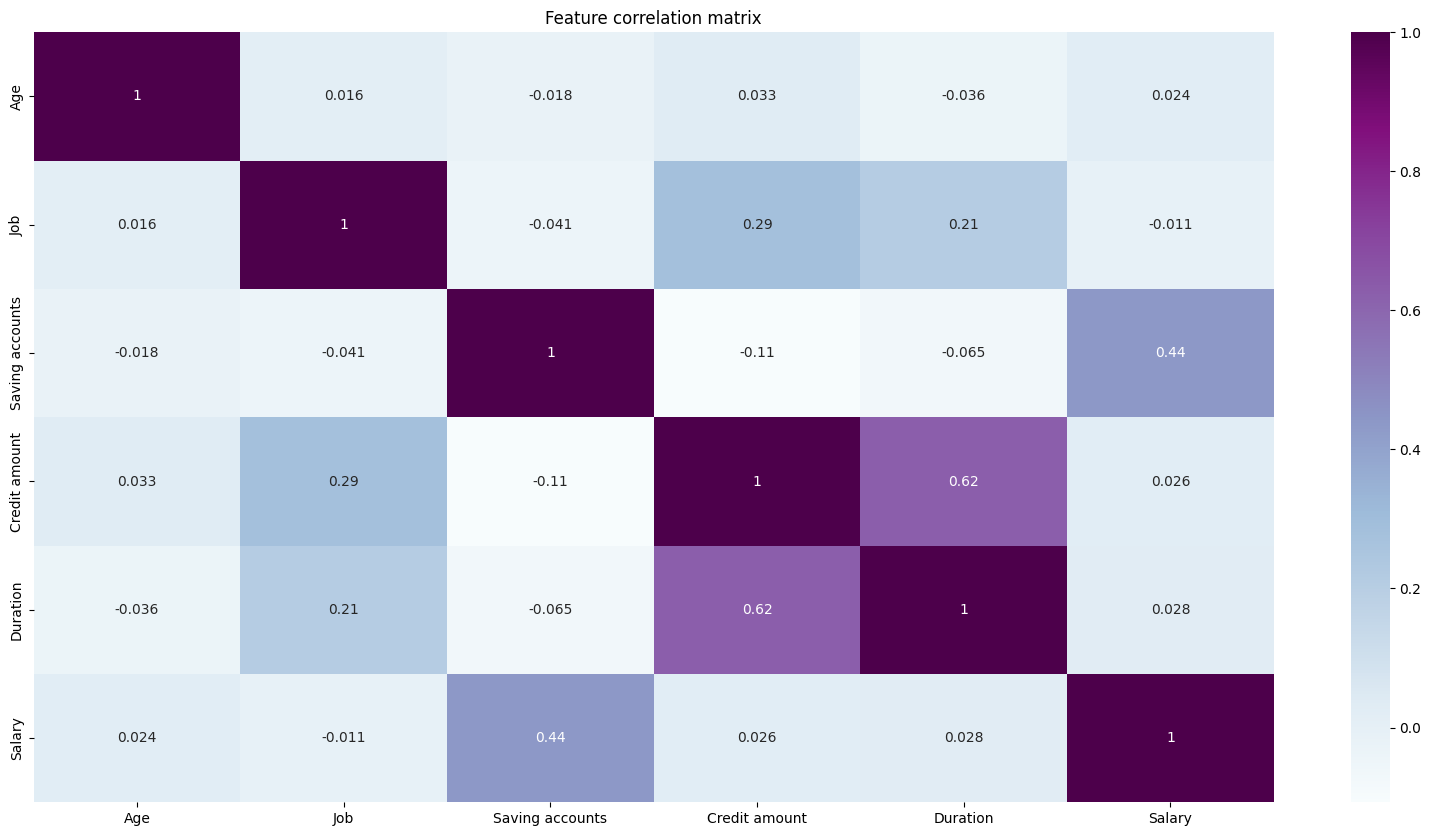

In [27]:
data_corr = data.drop(columns = ohe.get_feature_names_out(categorial_features))
plt.figure(figsize=(20, 10))
sns.heatmap(data_corr.corr(), annot=True, cmap='BuPu')
plt.title('Feature correlation matrix')
plt.show()

## Divide to features and targets

In [123]:
data['Ratio'] = data.apply(lambda row: debtToIncomeRatio(row['Salary'], row['Duration'], row['Credit amount']), axis=1)
X = data.drop(columns=['Credit amount'])
y = data['Credit amount'] > data['Credit amount'].median()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

In [124]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 

## Random forest

### Hyperparameter picking

In [125]:
estimators = [10, 50, 100, 300, 400, 500, 600]
min_samples_leaf = list(np.arange(1, 20, 5))
max_depth = list(np.arange(1, 5, 1))

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

In [126]:
clf = GridSearchCV(RandomForestClassifier(), grid_values, scoring='roc_auc', cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [np.int64(1), np.int64(2), np.int64(3),
                                       np.int64(4)],
                         'min_samples_leaf': [np.int64(1), np.int64(6),
                                              np.int64(11), np.int64(16)],
                         'n_estimators': [10, 50, 100, 300, 400, 500, 600]},
             scoring='roc_auc')

In [127]:
best_n_estimators_value = clf.best_params_['n_estimators']
best_min_samples_leaf = clf.best_params_['min_samples_leaf']
best_max_depth = clf.best_params_['max_depth']
best_score = clf.best_score_

print('Optimal trees amount: ', best_n_estimators_value)
print('Optimal leaves amount: ', best_min_samples_leaf)
print('Optimal depth: ', best_max_depth)
print('ROC-AUC: ', best_score)

Optimal trees amount:  600
Optimal leaves amount:  1
Optimal depth:  4
ROC-AUC:  0.9540169122344692


In [128]:
model = RandomForestClassifier(n_estimators=best_n_estimators_value,
                               max_depth=best_max_depth,
                               min_samples_leaf=best_min_samples_leaf,
                               random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### Quality check

In [130]:
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC score: {roc_auc}')

ROC-AUC score: 0.8642111601766358


In [131]:
importances = model.feature_importances_
features = pd.DataFrame({"feature": X.columns, 'importance': importances})
features.sort_values(by = 'importance', ascending = False)

feature  importance
3                      Duration    0.387679
22                        Ratio    0.314788
1                           Job    0.062956
4                        Salary    0.039676
19             Purpose_radio/TV    0.032081
0                           Age    0.030020
2               Saving accounts    0.017434
7                  Housing_free    0.013361
12        Checking account_rich    0.010488
5                    Sex_female    0.010314
6                      Sex_male    0.010056
15                  Purpose_car    0.009749
14             Purpose_business    0.009660
11    Checking account_moderate    0.009315
18  Purpose_furniture/equipment    0.008604
17            Purpose_education    0.007897
13         Checking account_unk    0.005619
8                   Housing_own    0.005409
16  Purpose_domestic appliances    0.004450
10      Checking account_little    0.003627
9                  Housing_rent    0.002735
21      Purpose_vacation/others    0.002536
20              Purpose_repairs    0.001545

In [132]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print('')
print("Confusion Matrix:")
print(conf_matrix)
print('')
print("Classification Report:")
print(class_report)

Accuracy: 0.865

Confusion Matrix:
[[93 13]
 [14 80]]

Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.88      0.87       106
        True       0.86      0.85      0.86        94

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



# 

## GradBoost Classifier

### Hyperparameter picking

In [133]:
estimators = [10, 50, 100, 300, 400, 500, 600]
min_samples_leaf = list(np.arange(1, 20, 5))
max_depth = list(np.arange(1, 10, 3))

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

In [134]:
clf = GridSearchCV(GradientBoostingClassifier(), grid_values, scoring='roc_auc', cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [np.int64(1), np.int64(4), np.int64(7)],
                         'min_samples_leaf': [np.int64(1), np.int64(6),
                                              np.int64(11), np.int64(16)],
                         'n_estimators': [10, 50, 100, 300, 400, 500, 600]},
             scoring='roc_auc')

In [135]:
best_n_estimators_value_boost = clf.best_params_['n_estimators']
best_min_samples_leaf_boost = clf.best_params_['min_samples_leaf']
best_max_depth_boost = clf.best_params_['max_depth']
best_score_boost = clf.best_score_

In [136]:
print('Optimal trees amount: ', best_n_estimators_value_boost)
print('Optimal leaves amount: ', best_min_samples_leaf_boost)
print('Optimal depth: ', best_max_depth_boost)
print('ROC-AUC: ', best_score_boost)

Optimal trees amount:  600
Optimal leaves amount:  6
Optimal depth:  1
ROC-AUC:  0.9940920207103187


In [137]:
gb_clf = GradientBoostingClassifier(n_estimators=best_n_estimators_value_boost,
                                    learning_rate=0.1,
                                    min_samples_leaf=best_min_samples_leaf_boost,
                                    max_depth=best_max_depth_boost,
                                    random_state=42)
gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)

## Quality check

In [138]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print('')
print("Confusion Matrix:")
print(conf_matrix)
print('')
print("Classification Report:")
print(class_report)

Accuracy: 0.965

Confusion Matrix:
[[102   4]
 [  3  91]]

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.96      0.97       106
        True       0.96      0.97      0.96        94

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



# 

### Result (TN and TP data)

In [143]:
data_test = data.iloc[y_test.index].copy()
data_test['Prediction'] = y_pred
data_test['Actual'] = y_test.values

# True Negatives: (low risk)
true_negatives = data_test[(data_test['Actual'] == 0) & (data_test['Prediction'] == 0)]

# True Positives: (high risk)
true_positives = data_test[(data_test['Actual'] == 1) & (data_test['Prediction'] == 1)]

In [144]:
print("True Negatives:")
display(true_negatives)

print("True Positives:")
display(true_positives)

True Negatives:


Age  Job  Saving accounts  Credit amount  Duration   Salary  Sex_female  \
660   23    2              1.0           1297        12  10417.5         0.0   
626   41    2              1.0           2116         6   9231.5         0.0   
513   20    2              1.0            585        12   7570.0         0.0   
811   28    1              1.0            484         6   8207.5         0.0   
636   28    2              3.0           1376        24  15408.0         1.0   
..   ...  ...              ...            ...       ...      ...         ...   
365   36    2              1.0           1542        12  11173.5         0.0   
942   31    2              0.0            929        24  10250.0         0.0   
948   43    1              1.0           1533        18   9488.5         0.0   
656   41    1              1.0            888        12  10775.5         0.0   
213   66    3              1.0           1908        30  10244.5         0.0   

     Sex_male  Housing_free  Housing_own  ...  Purpose_car  \
660       1.0           0.0          0.0  ...          0.0   
626       1.0           0.0          1.0  ...          0.0   
513       1.0           0.0          0.0  ...          0.0   
811       1.0           0.0          1.0  ...          0.0   
636       0.0           0.0          1.0  ...          0.0   
..        ...           ...          ...  ...          ...   
365       1.0           0.0          1.0  ...          0.0   
942       1.0           0.0          1.0  ...          0.0   
948       1.0           0.0          1.0  ...          0.0   
656       1.0           0.0          1.0  ...          1.0   
213       1.0           0.0          1.0  ...          0.0   

     Purpose_domestic appliances  Purpose_education  \
660                          0.0                0.0   
626                          0.0                0.0   
513                          0.0                0.0   
811                          0.0                0.0   
636                          0.0                0.0   
..                           ...                ...   
365                          0.0                0.0   
942                          0.0                0.0   
948                          0.0                0.0   
656                          0.0                0.0   
213                          0.0                0.0   

     Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  \
660                          0.0               1.0              0.0   
626                          1.0               0.0              0.0   
513                          0.0               1.0              0.0   
811                          0.0               1.0              0.0   
636                          0.0               1.0              0.0   
..                           ...               ...              ...   
365                          0.0               0.0              0.0   
942                          1.0               0.0              0.0   
948                          1.0               0.0              0.0   
656                          0.0               0.0              0.0   
213                          0.0               0.0              0.0   

     Purpose_vacation/others     Ratio  Prediction  Actual  
660                      0.0  1.037517       False   False  
626                      0.0  3.820253       False   False  
513                      0.0  0.643989       False   False  
811                      0.0  0.982841       False   False  
636                      0.0  0.372101       False   False  
..                       ...       ...         ...     ...  
365                      0.0  1.150043       False   False  
942                      0.0  0.377642       False   False  
948                      0.0  0.897578       False   False  
656                      0.0  0.686743       False   False  
213                      0.0  0.620821       False   False  

[102 rows x 26 columns]

True Positives:


Age  Job  Saving accounts  Credit amount  Duration   Salary  Sex_female  \
521   24    2              1.0           3190        18   8888.0         1.0   
737   35    1              2.0           4380        18  13112.5         0.0   
411   35    3              1.0           7253        33   9870.0         0.0   
678   64    1              1.0           2384        24  10040.0         0.0   
859   26    2              2.0           3577         9  11430.0         0.0   
..   ...  ...              ...            ...       ...      ...         ...   
408   26    3              3.0           3235        24  14212.5         0.0   
332   24    3              2.0           7408        60  13269.0         1.0   
208   21    1              1.0           6568        24   9911.0         0.0   
613   22    2              1.0           3632        24   9070.0         1.0   
78    39    1              0.0           9436        54  15383.0         0.0   

     Sex_male  Housing_free  Housing_own  ...  Purpose_car  \
521       0.0           0.0          1.0  ...          0.0   
737       1.0           0.0          1.0  ...          1.0   
411       1.0           0.0          1.0  ...          1.0   
678       1.0           0.0          0.0  ...          0.0   
859       1.0           0.0          0.0  ...          1.0   
..        ...           ...          ...  ...          ...   
408       1.0           0.0          1.0  ...          0.0   
332       0.0           0.0          1.0  ...          1.0   
208       1.0           0.0          1.0  ...          0.0   
613       0.0           0.0          0.0  ...          1.0   
78        1.0           0.0          1.0  ...          1.0   

     Purpose_domestic appliances  Purpose_education  \
521                          0.0                0.0   
737                          0.0                0.0   
411                          0.0                0.0   
678                          0.0                0.0   
859                          0.0                0.0   
..                           ...                ...   
408                          0.0                0.0   
332                          0.0                0.0   
208                          0.0                0.0   
613                          0.0                0.0   
78                           0.0                0.0   

     Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  \
521                          0.0               1.0              0.0   
737                          0.0               0.0              0.0   
411                          0.0               0.0              0.0   
678                          0.0               1.0              0.0   
859                          0.0               0.0              0.0   
..                           ...               ...              ...   
408                          0.0               1.0              0.0   
332                          0.0               0.0              0.0   
208                          0.0               0.0              0.0   
613                          0.0               0.0              0.0   
78                           0.0               0.0              0.0   

     Purpose_vacation/others     Ratio  Prediction  Actual  
521                      0.0  1.993949        True    True  
737                      0.0  1.855736        True    True  
411                      0.0  2.226828        True    True  
678                      0.0  0.989376        True    True  
859                      0.0  3.477204        True    True  
..                       ...       ...         ...     ...  
408                      0.0  0.948402        True    True  
332                      0.0  0.930490        True    True  
208                      0.0  2.761242        True    True  
613                      0.0  1.668504        True    True  
78                       0.0  1.135934        True    True  

[91 rows x 26 columns]